# EDA of taxi fares and trips in 2019


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

**Bussiness context** Exploring trends and find insights on demand of taxis along the year in NYC. Also try to correlate other known factors to the data.

**Data source:** The data for this EDA is based on 84.5 Million trips of NYC famous yellow cab in 2019. Originally based in SQLite. https://www.kaggle.com/datasets/dhruvildave/new-york-city-taxi-trips-2019.
For ease of data manipulation the data used in this notebook is filtered randomly for each month for a total of 20,000 rows for each month. 240,000 for the year.

Now lets dive in the data, import it to our workspace and create a dataframe containing said 240,000 rows.

In [24]:
# Importing data and concatenating csv into one df #
path = "./data/CSV"
files = glob.glob("../data/CSV/*.csv")
list = []
print("\tTHESE ARE THE DATA FILES: ")
for filename in files:
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    list.append(df)
df = pd.concat(list, axis=0, ignore_index=True)
df.drop(["congestion_surcharge"], axis=1, inplace=True)
df.describe()

	THESE ARE THE DATA FILES: 
../data/CSV\2019-1.csv
../data/CSV\2019-10.csv
../data/CSV\2019-11.csv
../data/CSV\2019-12.csv
../data/CSV\2019-2.csv
../data/CSV\2019-3.csv
../data/CSV\2019-4.csv
../data/CSV\2019-5.csv
../data/CSV\2019-6.csv
../data/CSV\2019-7.csv
../data/CSV\2019-8.csv
../data/CSV\2019-9.csv


,vendorid,passenger_count,trip_distance,ratecodeid,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,239282.000000,239282.000000,240000.000000,239282.000000,240000.000000,240000.000000,239282.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000
mean,1.646246,1.563189,3.008462,1.062445,163.024971,161.435729,1.290573,13.328827,1.090694,0.494589,2.191689,0.383478,0.298619,19.123983
std,0.497186,1.209468,3.941597,0.809382,66.079862,70.331723,0.478768,12.443881,1.247346,0.060650,2.791562,1.663988,0.027685,15.180889
min,1.000000,0.000000,-21.920000,1.000000,1.000000,1.000000,1.000000,-160.000000,-4.500000,-0.500000,-21.780000,-18.620000,-0.300000,-162.800000
25%,1.000000,1.000000,0.980000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,11.160000
50%,2.000000,1.000000,1.620000,1.000000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.860000,0.000000,0.300000,14.750000
75%,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,15.000000,2.500000,0.500000,2.950000,0.000000,0.300000,20.760000
max,4.000000,7.000000,93.960000,99.000000,265.000000,265.000000,4.000000,761.500000,8.250000,3.500000,220.000000,95.000000,0.300000,765.300000


Already is easy to see that some of our data is missing, indicated by the rows such as:

**passanger_count**

**ratecodeid**

**payment_type**



Also pandas statistical description already tells us of some important outliers such as:

A **tip_amount** of 220.00$ and another where it was -21.78$.

Some **tolls_amount** of 95 tolls in the same trip.

In [25]:
# Finding Nan values #
df.isna().sum()

vendorid                 718
tpep_pickup_datetime       0
tpep_dropoff_datetime      0
passenger_count          718
trip_distance              0
ratecodeid               718
store_and_fwd_flag       718
pulocationid               0
dolocationid               0
payment_type             718
fare_amount                0
extra                      0
mta_tax                    0
tip_amount                 0
tolls_amount               0
improvement_surcharge      0
total_amount               0
dtype: int64

In [26]:
# Droping NaN values
df.dropna(inplace=True)
# Arranging pickup and dropoff to a time in minutes #
df1 = df.copy()
df1['pickup_date'] = pd.to_datetime(df1["tpep_pickup_datetime"])
df1['dropoff_date'] = pd.to_datetime(df1["tpep_dropoff_datetime"])
df1['trip_duration_mins'] = round((df1['dropoff_date'] - df1['pickup_date']).dt.total_seconds() / 60, 3 )
df1['trip_duration_mins'].describe()

count    239282.000000
mean         17.881922
std          69.595354
min         -49.383000
25%           6.700000
50%          11.283000
75%          18.567000
max        4540.200000
Name: trip_duration_mins, dtype: float64

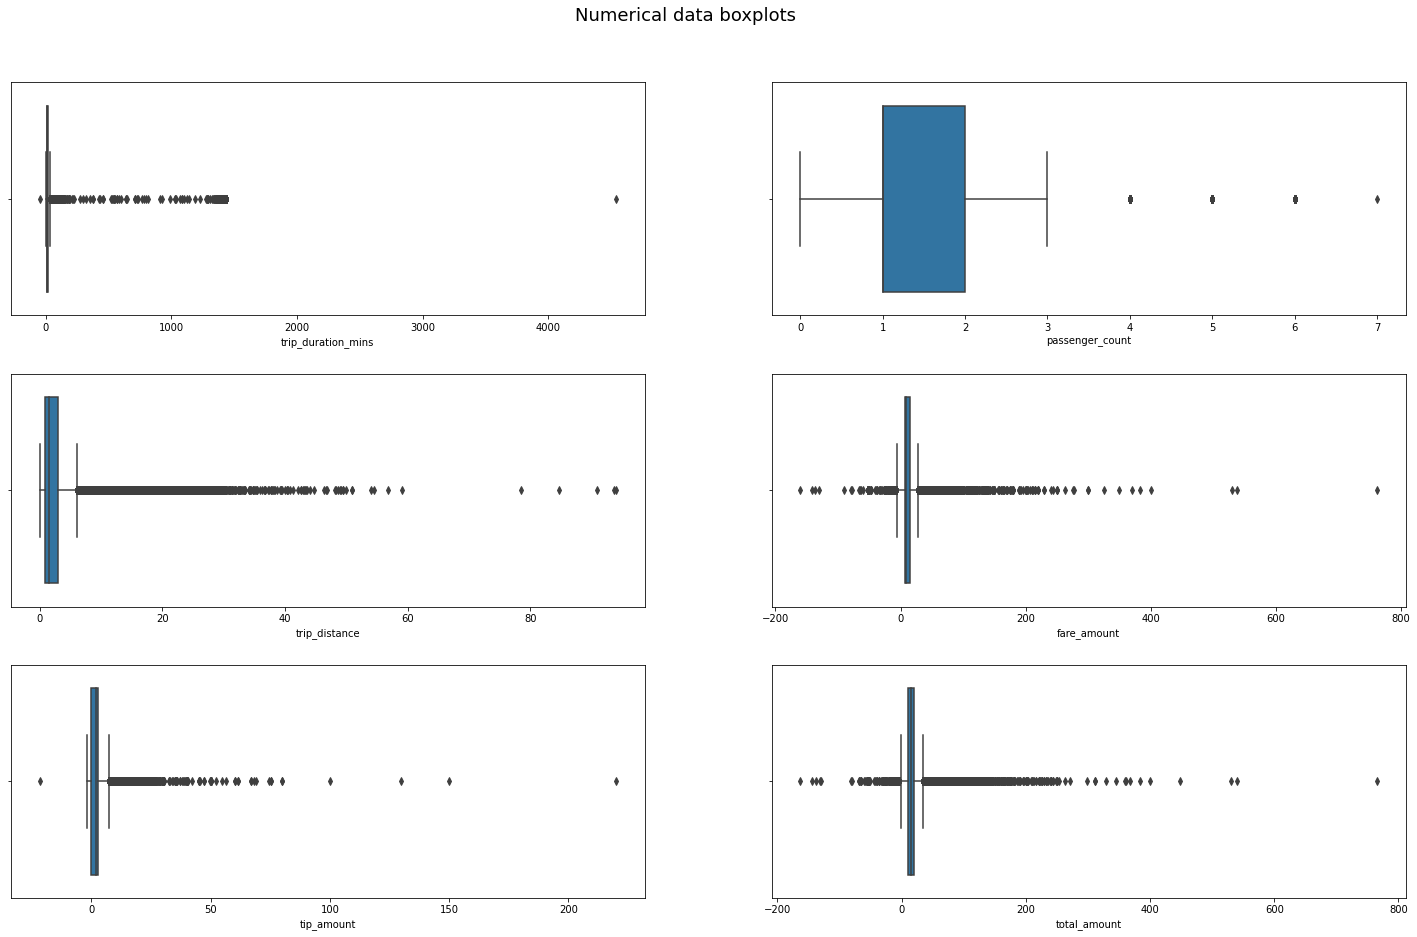

In [27]:
# Plotting numerical data to find trends #
num_col_list = ['trip_duration_mins', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
fig, axes = plt.subplots(3,2,figsize=(25, 15))
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Numerical data boxplots", fontsize=18, y=0.95)
# loop through tickers and axes
for col, ax in zip(num_col_list, axes.ravel()):
    sns.boxplot(data=df1, x=col, ax=ax)

In [28]:
# Managing outliers with ICR #a
col_names = ['total_amount','trip_duration_mins']
print("Original shape: ", df1.shape)
# loop for droping outlier based on IQR
for name in col_names:
    Q1 = np.percentile(df1[name], 25, method='midpoint')
    Q3 = np.percentile(df1[name], 75, method='midpoint')
    IQR = Q3-Q1
    upper = np.where(df1[name] >= (Q3 + 1.5*IQR))
    df1.drop(df1.index[upper[0]], inplace=True)
    lower = np.where(df1[name] <= (Q1 - 1.5*IQR))
    df1.drop(df1.index[lower[0]], inplace=True)
print("New shape: ", df1.shape)

Original shape:  (239282, 20)
New shape:  (210355, 20)


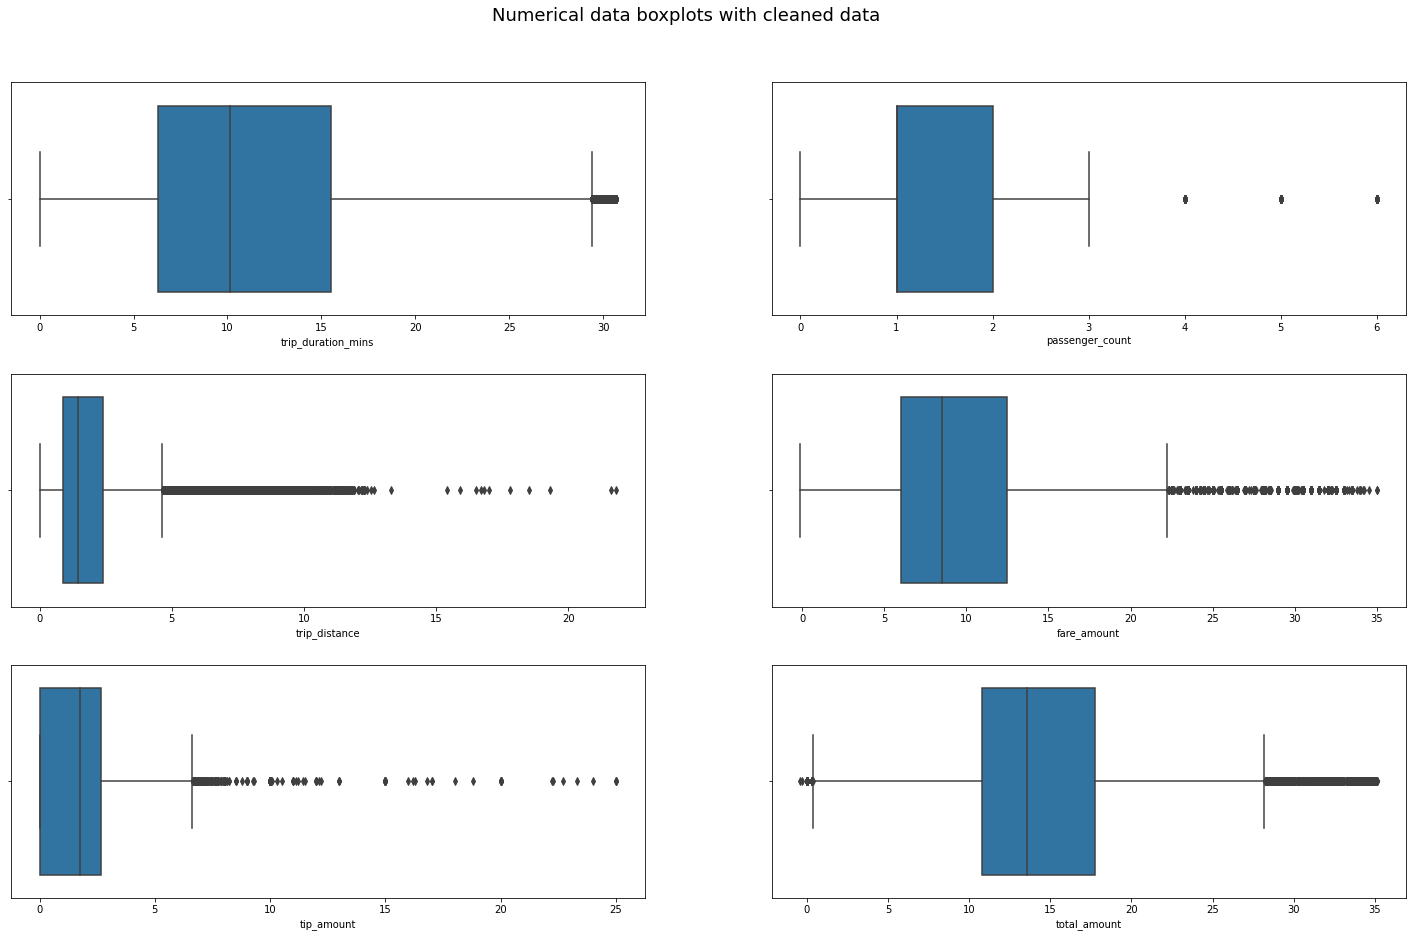

In [29]:
# Plotting the cleaned data after dropping outliers
fig, axes = plt.subplots(3,2,figsize=(25, 15))
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Numerical data boxplots with cleaned data", fontsize=18, y=0.95)
# loop thriugh tickers and axes
for col, ax in zip(num_col_list, axes.ravel()):
    sns.boxplot(data=df1, x=col, ax=ax)

In [30]:
df1.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_date,dropoff_date,trip_duration_mins
0,2.0,2019-01-01 00:41:40.000000,2019-01-01 00:46:19.000000,2.0,1.56,1.0,N,237.0,236.0,1.0,6.0,0.5,0.5,1.46,0.0,0.3,8.76,2019-01-01 00:41:40,2019-01-01 00:46:19,4.650
1,1.0,2019-01-04 06:19:38.000000,2019-01-04 06:20:48.000000,1.0,0.30,1.0,N,48.0,48.0,1.0,3.0,0.0,0.5,2.00,0.0,0.3,5.80,2019-01-04 06:19:38,2019-01-04 06:20:48,1.167
2,1.0,2019-01-07 10:00:42.000000,2019-01-07 10:08:18.000000,1.0,0.70,1.0,N,246.0,48.0,1.0,6.5,0.0,0.5,1.45,0.0,0.3,8.75,2019-01-07 10:00:42,2019-01-07 10:08:18,7.600
3,1.0,2019-01-06 18:45:43.000000,2019-01-06 18:54:48.000000,2.0,1.20,1.0,N,158.0,90.0,2.0,8.0,0.0,0.5,0.00,0.0,0.3,8.80,2019-01-06 18:45:43,2019-01-06 18:54:48,9.083
4,1.0,2019-01-18 16:51:26.000000,2019-01-18 17:03:13.000000,1.0,1.20,1.0,N,234.0,164.0,1.0,9.0,1.0,0.5,2.15,0.0,0.3,12.95,2019-01-18 16:51:26,2019-01-18 17:03:13,11.783


In [31]:
# Arranging categorical data
# Mapping payment methods to new col payment method
payment_method_dict = {
    1:'Credit Card',
    2:'Cash',
    3:'No Charge',
    4:'Dispute',
    5:'Unknown',
    6:'Voided Trip'
}
df1["payment_type"] = df["payment_type"].map(payment_method_dict)

# Mapping zones to borough df data
borough_csv_path = "../data/taxi_zone_lookup.csv"
df_boroughs = pd.read_csv(borough_csv_path)
for col in df_boroughs.columns:
    df1['pu_'+col] = df1["pulocationid"].map(df_boroughs[col])
    df1['do_'+col] = df1["dolocationid"].map(df_boroughs[col])

# Rearranging the df for proper readiing
cols_to_drop = ['vendorid','tpep_pickup_datetime','tpep_dropoff_datetime','store_and_fwd_flag','pulocationid','dolocationid','improvement_surcharge','mta_tax', 'pu_LocationID', 'do_LocationID']
df1.drop(columns=cols_to_drop, inplace=True)
df1 = df1[['pickup_date', 'dropoff_date', 'trip_duration_mins','passenger_count', 'trip_distance', 'ratecodeid', 'payment_type',
       'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'total_amount', 'pu_Borough', 'pu_Zone', 'pu_service_zone',
        'do_Borough', 'do_Zone','do_service_zone']]
df1.head()

,pickup_date,dropoff_date,trip_duration_mins,passenger_count,trip_distance,ratecodeid,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,pu_Borough,pu_Zone,pu_service_zone,do_Borough,do_Zone,do_service_zone
0,2019-01-01 00:41:40,2019-01-01 00:46:19,4.650,2.0,1.56,1.0,Credit Card,6.0,0.5,1.46,0.0,8.76,Manhattan,Upper West Side North,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
1,2019-01-04 06:19:38,2019-01-04 06:20:48,1.167,1.0,0.30,1.0,Credit Card,3.0,0.0,2.00,0.0,5.80,Brooklyn,Clinton Hill,Boro Zone,Brooklyn,Clinton Hill,Boro Zone
2,2019-01-07 10:00:42,2019-01-07 10:08:18,7.600,1.0,0.70,1.0,Credit Card,6.5,0.0,1.45,0.0,8.75,Bronx,West Concourse,Boro Zone,Brooklyn,Clinton Hill,Boro Zone
3,2019-01-06 18:45:43,2019-01-06 18:54:48,9.083,2.0,1.20,1.0,Cash,8.0,0.0,0.00,0.0,8.80,Bronx,Melrose South,Boro Zone,Brooklyn,Flatlands,Boro Zone
4,2019-01-18 16:51:26,2019-01-18 17:03:13,11.783,1.0,1.20,1.0,Credit Card,9.0,1.0,2.15,0.0,12.95,Bronx,University Heights/Morris Heights,Boro Zone,Brooklyn,Midwood,Boro Zone


ValueError: Could not interpret input 'destiny'

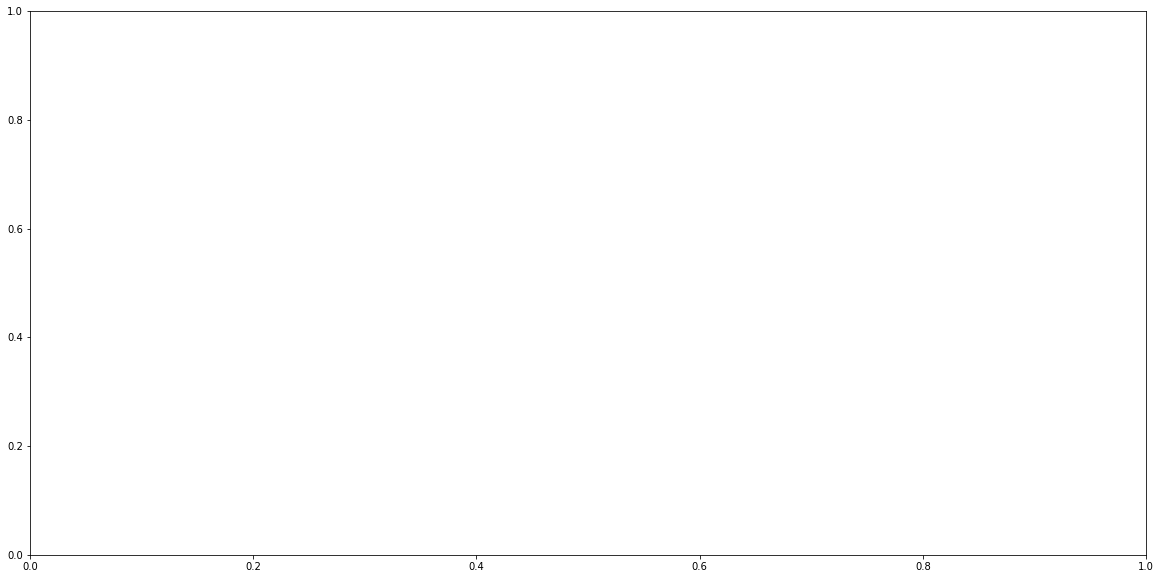

In [32]:
df1['destination'] = df1['pu_Borough'] + '_' + df1['do_Borough']
df1 = df1[df1['pu_Borough'] != 'Unknown']
df1 = df1[df1['do_Borough'] != 'Unknown']
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df1, x='destiny', hue='payment_type', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle("Destination frequency", fontsize=18, y=0.95)
plt.show()

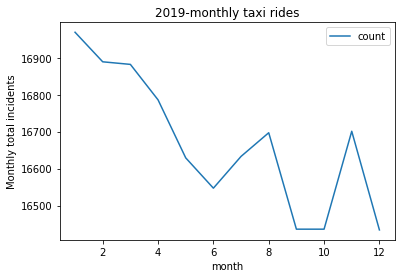

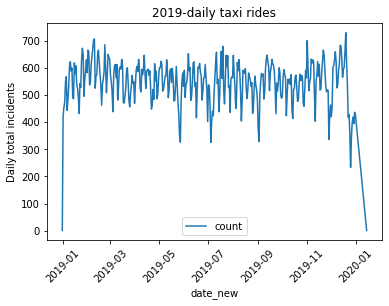

In [ ]:
#Plotting time trends for month and weekday
df2 = df1.copy()
def plot_time( df, time_var, title, rot = 0):
    res = df2.groupby([time_var])['payment_type'].count().reset_index(name="count")
    p = res.plot(x = time_var, y = "count", title = title, rot = rot)
    return p

df2["month"] = df2['pickup_date'].dt.month
plot_monthly = plot_time( df2, "month", "2019-monthly taxi rides")
_ = plt.ylabel("Monthly total incidents")

df2["date_new"] = df2["pickup_date"].dt.date
# rotate the x-axis tick labels for better visualization
plot_daily = plot_time( df2, "date_new", "2019-daily taxi rides", rot = 45)
_ = plt.ylabel("Daily total incidents")

In [ ]:
df2.head()

,pickup_date,dropoff_date,trip_duration_mins,passenger_count,trip_distance,ratecodeid,payment_type,fare_amount,extra,tip_amount,...,total_amount,pu_Borough,pu_Zone,pu_service_zone,do_Borough,do_Zone,do_service_zone,destiny,month,date_new
0,2019-01-01 00:41:40,2019-01-01 00:46:19,4.650,2.0,1.56,1.0,Credit Card,6.0,0.5,1.46,...,8.76,Manhattan,Upper West Side North,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone,Manhattan_Manhattan,1,2019-01-01
1,2019-01-04 06:19:38,2019-01-04 06:20:48,1.167,1.0,0.30,1.0,Credit Card,3.0,0.0,2.00,...,5.80,Brooklyn,Clinton Hill,Boro Zone,Brooklyn,Clinton Hill,Boro Zone,Brooklyn_Brooklyn,1,2019-01-04
2,2019-01-07 10:00:42,2019-01-07 10:08:18,7.600,1.0,0.70,1.0,Credit Card,6.5,0.0,1.45,...,8.75,Bronx,West Concourse,Boro Zone,Brooklyn,Clinton Hill,Boro Zone,Bronx_Brooklyn,1,2019-01-07
3,2019-01-06 18:45:43,2019-01-06 18:54:48,9.083,2.0,1.20,1.0,Cash,8.0,0.0,0.00,...,8.80,Bronx,Melrose South,Boro Zone,Brooklyn,Flatlands,Boro Zone,Bronx_Brooklyn,1,2019-01-06
4,2019-01-18 16:51:26,2019-01-18 17:03:13,11.783,1.0,1.20,1.0,Credit Card,9.0,1.0,2.15,...,12.95,Bronx,University Heights/Morris Heights,Boro Zone,Brooklyn,Midwood,Boro Zone,Bronx_Brooklyn,1,2019-01-18


In [14]:
# Is there a correlation in the total_amount with some of the other variables? #
df2.corr()

,trip_duration_mins,passenger_count,trip_distance,ratecodeid,fare_amount,extra,tip_amount,tolls_amount,total_amount,month
trip_duration_mins,1.000000,0.008490,0.681905,-0.004338,0.904487,0.009834,0.349644,0.050039,0.873671,0.041097
passenger_count,0.008490,1.000000,0.012098,-0.002550,0.008581,-0.173715,-0.004745,-0.001006,0.007148,-0.008844
trip_distance,0.681905,0.012098,1.000000,0.001551,0.905076,-0.028879,0.288529,0.134275,0.846097,-0.001234
ratecodeid,-0.004338,-0.002550,0.001551,1.000000,0.008313,-0.012729,-0.013014,0.010898,-0.001027,-0.007040
fare_amount,0.904487,0.008581,0.905076,0.008313,1.000000,-0.011161,0.341293,0.103016,0.944957,0.024443
extra,0.009834,-0.173715,-0.028879,-0.012729,-0.011161,1.000000,0.036492,-0.014045,0.060495,0.077420
tip_amount,0.349644,-0.004745,0.288529,-0.013014,0.341293,0.036492,1.000000,0.015459,0.581566,0.031910
tolls_amount,0.050039,-0.001006,0.134275,0.010898,0.103016,-0.014045,0.015459,1.000000,0.145151,-0.005277
total_amount,0.873671,0.007148,0.846097,-0.001027,0.944957,0.060495,0.581566,0.145151,1.000000,0.087265
month,0.041097,-0.008844,-0.001234,-0.007040,0.024443,0.077420,0.031910,-0.005277,0.087265,1.000000
